In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.4 MB/s eta 0:00:00


In [ ]:
from ultralytics import RTDETR

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from math import ceil
from torchvision import models, transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_dir = "/content/drive/MyDrive/Malariae/images/valid"
save_dir = "new_predicted_images"
os.makedirs(save_dir, exist_ok=True)

images_per_row = 4
CONF_THRESH = 0.5

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/resnet_malaria.pth"
NUM_CLASSES = 5

CLASS_NAMES = [
    "Falciparum",
    "Vivax",
    "Ovale",
    "Malariae",
    "Uninfected"
]

In [ ]:
STAGE_NAMES = {
    "Falciparum": ["Ring", "Trophozoite", "Schizont", "Gametocyte"],
    "Ovale": ["Ring", "Trophozoite", "Schizont", "Gametocyte"],
    "Vivax": ["Ring",  "Trophozoite", "Schizont", "Gametocyte"],
    "Malariae": ["Ring", "Trophozoite", "Schizont", "Gametocyte"]
}

In [ ]:
def load_resnet_model(weight_path):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

    state_dict = torch.load(weight_path, map_location=DEVICE)
    model.load_state_dict(state_dict)

    model.to(DEVICE)
    model.eval()
    return model

main_model = load_resnet_model(MODEL_PATH)
print("✅ ResNet model loaded")

✅ ResNet model loaded


In [ ]:
def infer_num_classes_from_ckpt(weight_path):
    ckpt = torch.load(weight_path, map_location="cpu")
    return ckpt["roi_heads.box_predictor.cls_score.weight"].shape[0]


def load_frcnn_model(weight_path, device):
    num_classes = infer_num_classes_from_ckpt(weight_path)

    model = fasterrcnn_resnet50_fpn(
        weights=None,
        num_classes=num_classes
    )

    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()

    print(f"Loaded {weight_path} with num_classes={num_classes}")
    return model

In [ ]:
subclass_models = {
    "Falciparum": RTDETR("/content/drive/MyDrive/Malaria_Falcip_augmented/RTDR_results/weights/best.pt"),
    "Ovale": RTDETR("/content/drive/MyDrive/Ovale_data_augmented/ovale_results/train/weights/best.pt"),
    "Vivax": RTDETR("/content/drive/MyDrive/Vivax_data_augmented/vivax_results/train/weights/best.pt"),
    "Malariae": RTDETR("/content/drive/MyDrive/Malariae_data_augmented/rtdetr_tmp/train/weights/best.pt"),
}

print("✅ RT-DETR models loaded")

✅ RT-DETR models loaded


In [ ]:
def run_rtdetr(model, image_bgr, conf_thresh=0.5):
    results = model.predict(
        source=image_bgr,
        imgsz=640,
        conf=conf_thresh,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )

    detections = []

    if results and results[0].boxes is not None:
        for box, cls, score in zip(
            results[0].boxes.xyxy.cpu().numpy(),
            results[0].boxes.cls.cpu().numpy(),
            results[0].boxes.conf.cpu().numpy()
        ):
            x1, y1, x2, y2 = map(int, box)
            detections.append((x1, y1, x2, y2, int(cls), float(score)))

    return detections

In [ ]:
def predict_and_draw(image_path, save_path=None, conf_thresh=0.5):
    img = cv2.imread(str(image_path))
    original_img = img.copy()

    # ---------- RESNET (Parent classification) ----------
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb)

    resnet_input = resnet_transform(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = resnet_model(resnet_input)
        pred_idx = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][pred_idx].item()

    parent_class = CLASS_NAMES[pred_idx]

    cv2.putText(
        original_img,
        f"{parent_class} ({confidence:.2f})",
        (20, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.5,
        (0, 255, 0),
        3
    )

    boxes_out = []

    # ---------- RT-DETR (Stage detection) ----------
    if parent_class in subclass_models:
        rtdetr_model = subclass_models[parent_class]

        detections = run_rtdetr(
            rtdetr_model,
            original_img,
            conf_thresh
        )

        for x1, y1, x2, y2, cls_id, score in detections:
            label = f"Stage {cls_id} ({score:.2f})"

            cv2.rectangle(original_img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(
                original_img,
                label,
                (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 0, 0),
                2
            )

            boxes_out.append({
                "bbox": [x1, y1, x2, y2],
                "class_id": cls_id,
                "confidence": score,
                "model": "RT-DETR"
            })

    if save_path:
        cv2.imwrite(str(save_path), original_img)

    return parent_class, confidence, boxes_out, original_img

In [ ]:
resnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

frcnn_transform = transforms.ToTensor()

In [ ]:
def load_images_from_dir(directory):
    return sorted([p for p in Path(directory).rglob("*")
                   if p.suffix.lower() in [".jpg", ".png", ".jpeg"]])

In [ ]:
def predict_and_draw(image_path, save_path=None):
    img = cv2.imread(str(image_path))
    original_img = img.copy()

    # ---------- RESNET ----------
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resnet_input = resnet_transform(rgb).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = main_model(resnet_input)
        pred_idx = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][pred_idx].item()

    parent_class = CLASS_NAMES[pred_idx]

    cv2.putText(
        original_img,
        f"{parent_class} ({confidence:.2f})",
        (20, 80),
        cv2.FONT_HERSHEY_SIMPLEX,
        1.9,
        (0, 255, 0),
        3
    )

    boxes_out = []

    # ---------- FASTER R-CNN ----------
    if parent_class in subclass_frcnn_models:
        model = subclass_frcnn_models[parent_class]

        with torch.no_grad():
            [0]

        boxes = output["boxes"].cpu().numpy()
        labels = output["labels"].cpu().numpy()
        scores = output["scores"].cpu().numpy()

        stage_names = STAGE_NAMES[parent_class]

        for box, label, score in zip(boxes, labels, scores):
            if score < CONF_THRESH:
                continue

            x1, y1, x2, y2 = map(int, box)
            stage = stage_names[label - 1]

            cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(
                original_img,
                f"{stage} ({score:.2f})",
                (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.1,
                (0, 0, 255),
                2
            )

            boxes_out.append((x1, y1, x2, y2, stage, score))

    if save_path:
        cv2.imwrite(save_path, original_img)

    return original_img, parent_class, boxes_out

In [ ]:
def predict_and_draw(image_path, save_path=None):
    img = cv2.imread(str(image_path))
    original_img = img.copy()

    # ---------- HELPER: DRAW READABLE LABEL ----------
    def draw_label_readable(img, text, pos,
                            font_scale=2.0, thickness=4,
                            text_color=(255,255,255),
                            bg_color=(0,0,180),
                            padding=10):
        x, y = pos
        font = cv2.FONT_HERSHEY_SIMPLEX
        (w, h), baseline = cv2.getTextSize(text, font, font_scale, thickness)

        # Draw solid rectangle background
        cv2.rectangle(img,
                      (x, y - h - baseline - padding),
                      (x + w + padding*2, y + padding),
                      bg_color,
                      -1)

        # Draw text
        cv2.putText(img,
                    text,
                    (x + padding, y - padding),
                    font,
                    font_scale,
                    text_color,
                    thickness,
                    cv2.LINE_AA)

    # ---------- RESNET SPECIES PREDICTION ----------
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resnet_input = resnet_transform(rgb).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits = main_model(resnet_input)
        pred_idx = torch.argmax(logits, dim=1).item()
        confidence = torch.softmax(logits, dim=1)[0][pred_idx].item()

    parent_class = CLASS_NAMES[pred_idx]

    # Draw species label (top-left corner) with readable background
    draw_label_readable(
        original_img,
        f"{parent_class} ({confidence:.2f})",
        (20, 80),
        font_scale=2.0,
        thickness=4,
        text_color=(255,255,255),
        bg_color=(0,140,0)  # dark green for species
    )

    boxes_out = []

    # ---------- FASTER R-CNN STAGE DETECTION ----------
    if parent_class in subclass_frcnn_models:
        model = subclass_frcnn_models[parent_class]
        img_tensor = frcnn_transform(rgb).to(DEVICE)

        with torch.no_grad():
            output = model([img_tensor])[0]

        boxes = output["boxes"].cpu().numpy()
        labels = output["labels"].cpu().numpy()
        scores = output["scores"].cpu().numpy()

        stage_names = STAGE_NAMES[parent_class]

        for box, label, score in zip(boxes, labels, scores):
            if score < CONF_THRESH:
                continue

            x1, y1, x2, y2 = map(int, box)
            stage = stage_names[label - 1]

            # Draw bounding box
            cv2.rectangle(original_img, (x1, y1), (x2, y2), (0, 0, 255), 3)

            # Draw stage label with readable background
            draw_label_readable(
                original_img,
                f"{stage} ({score:.2f})",
                (x1, max(30, y1)),  # avoid text going outside top
                font_scale=1.6,
                thickness=3,
                text_color=(255,255,255),
                bg_color=(0,0,180)  # dark blue for stage
            )

            boxes_out.append((x1, y1, x2, y2, stage, score))

    if save_path:
        cv2.imwrite(save_path, original_img)

    return original_img, parent_class, boxes_out

In [ ]:
image_paths = load_images_from_dir(image_dir)
annotated_images = []

for img_path in image_paths:
    img_name = os.path.basename(img_path)
    save_path = os.path.join(save_dir, img_name)

    img, parent_class, boxes = predict_and_draw(img_path, save_path)
    annotated_images.append(img)

print(f"✅ Annotated {len(annotated_images)} images saved")

✅ Annotated 3 images saved


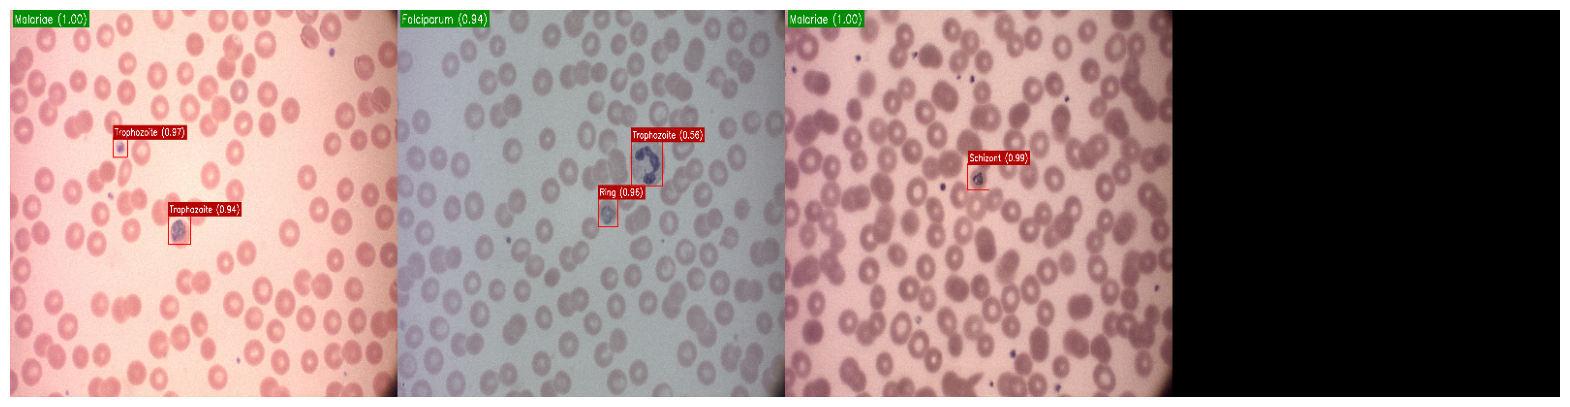

In [ ]:
if annotated_images:
    target_h, target_w = 400, 400
    resized = [cv2.resize(img, (target_w, target_h)) for img in annotated_images]

    rows = ceil(len(resized) / images_per_row)
    grid = []

    for r in range(rows):
        row_imgs = resized[r*images_per_row:(r+1)*images_per_row]
        while len(row_imgs) < images_per_row:
            row_imgs.append(np.zeros_like(resized[0]))
        grid.append(np.hstack(row_imgs))

    grid_image = np.vstack(grid)
    cv2.imwrite(os.path.join(save_dir, "new_annotated_grid.jpg"), grid_image)

    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(grid_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [ ]:
NUM_CLASSES = 4
CLASS_NAMES = ["Falciparum", "Ovale", "Vivax", "Malariae"]

# Build ResNet architecture
resnet_model = models.resnet50(pretrained=False)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, NUM_CLASSES)

# Load weights (state_dict)
state_dict = torch.load(
    "/content/drive/MyDrive/resnet_malaria.pth",
    map_location=DEVICE
)

resnet_model.load_state_dict(state_dict)
resnet_model = resnet_model.to(DEVICE)
resnet_model.eval()

print("✅ ResNet state_dict loaded correctly")


RuntimeError: Error(s) in loading state_dict for ResNet:
	Missing key(s) in state_dict: "layer1.0.conv3.weight", "layer1.0.bn3.weight", "layer1.0.bn3.bias", "layer1.0.bn3.running_mean", "layer1.0.bn3.running_var", "layer1.0.downsample.0.weight", "layer1.0.downsample.1.weight", "layer1.0.downsample.1.bias", "layer1.0.downsample.1.running_mean", "layer1.0.downsample.1.running_var", "layer1.1.conv3.weight", "layer1.1.bn3.weight", "layer1.1.bn3.bias", "layer1.1.bn3.running_mean", "layer1.1.bn3.running_var", "layer1.2.conv1.weight", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.conv2.weight", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.conv3.weight", "layer1.2.bn3.weight", "layer1.2.bn3.bias", "layer1.2.bn3.running_mean", "layer1.2.bn3.running_var", "layer2.0.conv3.weight", "layer2.0.bn3.weight", "layer2.0.bn3.bias", "layer2.0.bn3.running_mean", "layer2.0.bn3.running_var", "layer2.1.conv3.weight", "layer2.1.bn3.weight", "layer2.1.bn3.bias", "layer2.1.bn3.running_mean", "layer2.1.bn3.running_var", "layer2.2.conv1.weight", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.conv2.weight", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.conv3.weight", "layer2.2.bn3.weight", "layer2.2.bn3.bias", "layer2.2.bn3.running_mean", "layer2.2.bn3.running_var", "layer2.3.conv1.weight", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.conv2.weight", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.conv3.weight", "layer2.3.bn3.weight", "layer2.3.bn3.bias", "layer2.3.bn3.running_mean", "layer2.3.bn3.running_var", "layer3.0.conv3.weight", "layer3.0.bn3.weight", "layer3.0.bn3.bias", "layer3.0.bn3.running_mean", "layer3.0.bn3.running_var", "layer3.1.conv3.weight", "layer3.1.bn3.weight", "layer3.1.bn3.bias", "layer3.1.bn3.running_mean", "layer3.1.bn3.running_var", "layer3.2.conv1.weight", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.conv2.weight", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.conv3.weight", "layer3.2.bn3.weight", "layer3.2.bn3.bias", "layer3.2.bn3.running_mean", "layer3.2.bn3.running_var", "layer3.3.conv1.weight", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.conv2.weight", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.conv3.weight", "layer3.3.bn3.weight", "layer3.3.bn3.bias", "layer3.3.bn3.running_mean", "layer3.3.bn3.running_var", "layer3.4.conv1.weight", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.conv2.weight", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.conv3.weight", "layer3.4.bn3.weight", "layer3.4.bn3.bias", "layer3.4.bn3.running_mean", "layer3.4.bn3.running_var", "layer3.5.conv1.weight", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.conv2.weight", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.conv3.weight", "layer3.5.bn3.weight", "layer3.5.bn3.bias", "layer3.5.bn3.running_mean", "layer3.5.bn3.running_var", "layer4.0.conv3.weight", "layer4.0.bn3.weight", "layer4.0.bn3.bias", "layer4.0.bn3.running_mean", "layer4.0.bn3.running_var", "layer4.1.conv3.weight", "layer4.1.bn3.weight", "layer4.1.bn3.bias", "layer4.1.bn3.running_mean", "layer4.1.bn3.running_var", "layer4.2.conv1.weight", "layer4.2.bn1.weight", "layer4.2.bn1.bias", "layer4.2.bn1.running_mean", "layer4.2.bn1.running_var", "layer4.2.conv2.weight", "layer4.2.bn2.weight", "layer4.2.bn2.bias", "layer4.2.bn2.running_mean", "layer4.2.bn2.running_var", "layer4.2.conv3.weight", "layer4.2.bn3.weight", "layer4.2.bn3.bias", "layer4.2.bn3.running_mean", "layer4.2.bn3.running_var". 
	size mismatch for layer1.0.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 64, 1, 1]).
	size mismatch for layer1.1.conv1.weight: copying a param with shape torch.Size([64, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 256, 1, 1]).
	size mismatch for layer2.0.conv1.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 256, 1, 1]).
	size mismatch for layer2.0.downsample.0.weight: copying a param with shape torch.Size([128, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 256, 1, 1]).
	size mismatch for layer2.0.downsample.1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.running_mean: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.0.downsample.1.running_var: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for layer2.1.conv1.weight: copying a param with shape torch.Size([128, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 512, 1, 1]).
	size mismatch for layer3.0.conv1.weight: copying a param with shape torch.Size([256, 128, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 512, 1, 1]).
	size mismatch for layer3.0.downsample.0.weight: copying a param with shape torch.Size([256, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([1024, 512, 1, 1]).
	size mismatch for layer3.0.downsample.1.weight: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.running_mean: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.0.downsample.1.running_var: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([1024]).
	size mismatch for layer3.1.conv1.weight: copying a param with shape torch.Size([256, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 1024, 1, 1]).
	size mismatch for layer4.0.conv1.weight: copying a param with shape torch.Size([512, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.0.weight: copying a param with shape torch.Size([512, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2048, 1024, 1, 1]).
	size mismatch for layer4.0.downsample.1.weight: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.running_mean: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.0.downsample.1.running_var: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for layer4.1.conv1.weight: copying a param with shape torch.Size([512, 512, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 2048, 1, 1]).
	size mismatch for fc.weight: copying a param with shape torch.Size([5, 512]) from checkpoint, the shape in current model is torch.Size([4, 2048]).
	size mismatch for fc.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([4]).